## Import Statements

In [14]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

from os.path import join
from src.training import HyperparameterSearch
from src.data_loading import prepare_ground_truth_data
from sklearn.metrics import precision_score, recall_score, f1_score



## Training Approach

Training the data on a five-label classification problem for all heart issues seems unfeasible. Thus, we train the data on a binary classification of being healthy or pathological. We define pathological as every diagnostic superclass that is not "NORM."

To this end, we train a basic CNN model on the task of binary classification.

In [10]:
data_path = "../data/processed"
X = np.load(join(data_path, "X.npy"))
Y = pd.read_csv(join(data_path, "y.csv"))

print(os.getcwd())
model_path = "../param_search"

/Users/justinalbert/Development/Idoven-DS-Machine-Learning/notebooks


## Investigate Data Distribution of Labels

We first investigate the data distribution of the ground truth labels. The distribution between healthy and pathologic classes is minor. Thus, we do not consider any more advanced class imbalance methods.  

/var/folders/f3/sjrhhs9n24n82n8gvmbk37y00000gn/T/ipykernel_5402/922436849.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


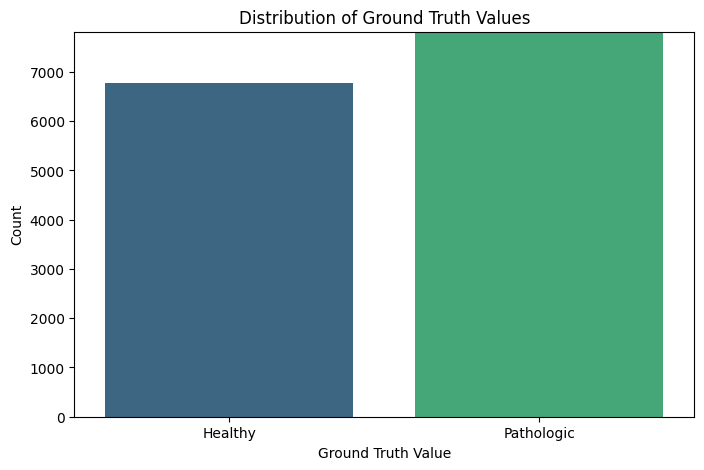

In [11]:
class_counts = Y['ground_truth'].apply(lambda x: x).value_counts()

# Plotting the distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Distribution of Ground Truth Values')
plt.xlabel('Ground Truth Value')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Healthy', 'Pathologic'])
plt.ylim(0, class_counts.max() + 1)  # Add some space above bars for aesthetics
plt.show()

## Network Architecture

For this experiment, we define a simpler version of a Convolutional Neural Network that consists of three stacked convolutional layers, fed into fully-connected layers and ultimately predicting a probability of sample belonging to either healthy or patient class. 

## Hyperparameter Optimization

We implemented a hyperparameter search using scikit-learn optimize that uses a k_fold split with adjustable fold numbers. Due to computing restrictions, the number of folds is currently set to 3. For the test set, we utilize the fixed stratified fold as recommended by Physionet. Given the larger dataset and the limited training size, we reduce the steps of the hyperparameter search to n=10.

For this early experiment, we conduct a hyperparameter search for the following parameters:

- Batch Size
- Learning Rate
- Dropout Rate
- Convolutional Filters (3 layers)

For runtime purposes (running experiments locally on the CPU of a MacBook Air 2018), we select a rather large stride of n=100 and a window size of 100 frames. This should be increased when having enough computing power at hand.

In [12]:
test_fold = 10

Y["ground_truth"] = Y["ground_truth"].apply(lambda x: [x])  # Wrap labels into list for PyTorch Tensors

X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)]
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold]

WINDOW_SIZE = 100
STRIDE = 200
N_EPOCHS = 1
FOLDS = 2

opt_search = HyperparameterSearch(X_train, y_train, X_test, y_test, model_path, WINDOW_SIZE, STRIDE, N_EPOCHS, FOLDS)


## Starting Hyperparameter Optimization

The next cell is executing the hyperparameter search with the desired number of trials.

In [ ]:
opt_search.perform_search(n_calls=10)

## Model evaluation

After performing the hyperparameter optimization, we investigate the model performance on the pre-defined test set. To this end, we load the stored best hyperparameter combination and retrain the model on the entire training data.

[9, 0.0017249321573178998, 0.45298479650686513, (32, 64, 128)]


Epoch 1/1: 100%|██████████| 7304/7304 [02:35<00:00, 47.02batch/s, loss=0.432]


Train loss: 0.4315445964331234


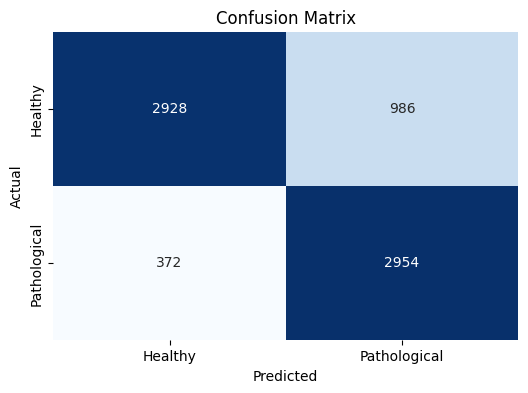

In [13]:
with open(join(model_path, "best_params.pkl"), 'rb') as file:
    loaded_results = pickle.load(file)

print(loaded_results)
predictions, labels = opt_search.evaluate_model(loaded_results)

# Calculate confusion matrix
# Manually calculate confusion matrix values
TP = sum((l == 1 and p == 1) for l, p in zip(labels, predictions))
TN = sum((l == 0 and p == 0) for l, p in zip(labels, predictions))
FP = sum((l == 0 and p == 1) for l, p in zip(labels, predictions))
FN = sum((l == 1 and p == 0) for l, p in zip(labels, predictions))

# Create confusion matrix as a 2x2 list, usually one would use the sklearn confusion matrix function. Due to numpy and pytorch compability issues right now, I'm calculating it manually
conf_matrix = [[TN, FP], [FN, TP]]

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Healthy', 'Pathological'], yticklabels=['Healthy', 'Pathological'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Classification Results

From the predicted classes, we calculate the typical classification evlauation metrics, including precision, recall, and F1 score. 

In [15]:
precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)
f1 = f1_score(labels, predictions)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Precision: 0.7497
Recall: 0.8882
F1-Score: 0.8131


## Next Actions

We initially explored the given Physionet dataset and focused on predicting healthy and pathologic patients given a 10-second ECG data interval. Due to restrictions in time and especially the available computing resources on my end, we propose to take the next actions in advancing this project:  

- Expanding the hyperparameter optimization. This includes more epochs, more k-folds, and a larger parameter space.
  
- In-depth evaluation of the hyperparameter search, analyzing the importance and influence of specific hyperparameters.

- Including more advanced models. In this work, we have focused on a basic CNN model that processes the time series. More advanced methods, including time-series recurrent neural networks, could be tested.

- Explainable AI (XAI) involves trying to understand which features in the input data are most relevant for the network to reach a certain conclusion. For example, feature activation maps could reveal more important information.